In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from PotentialClassifier import PotentialClassifier


from tqdm import tqdm

<img src="task 1.png">

In [27]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

## Посмотрим на данные

Text(0, 0.5, 'petal width (cm)')

<Figure size 640x480 with 0 Axes>

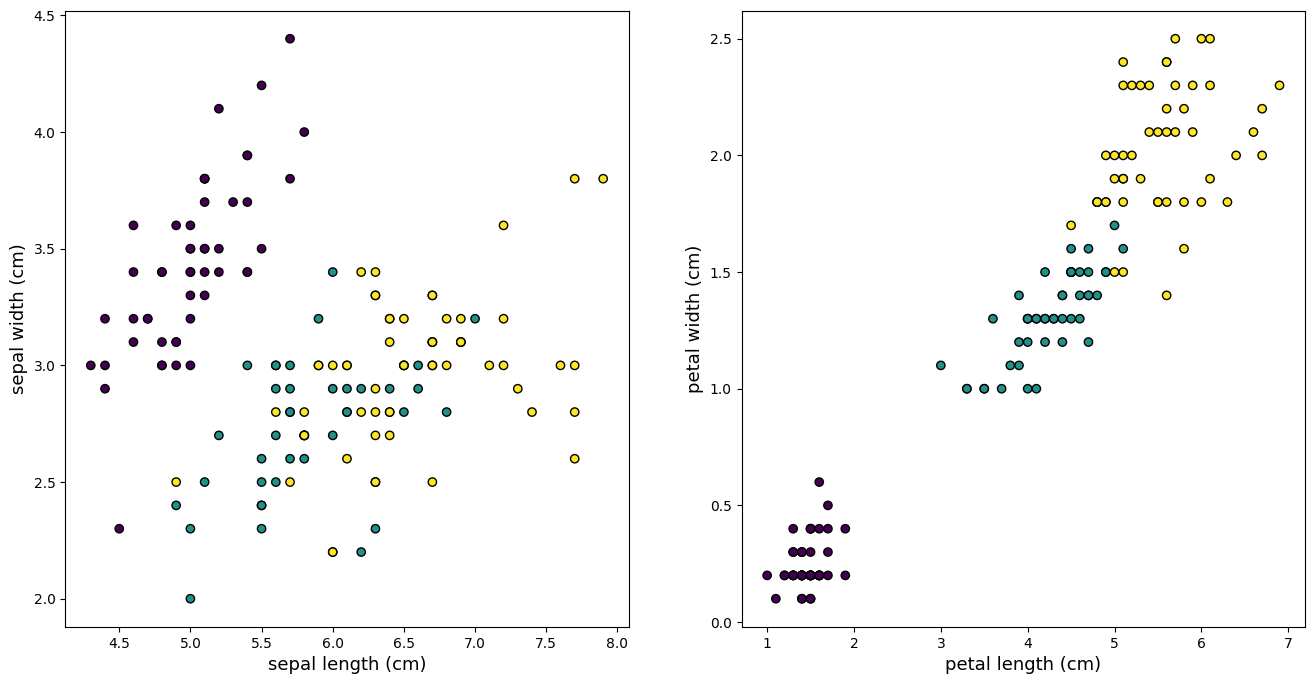

In [28]:
feature_names = iris.feature_names

plt.clf()
fig = plt.figure(figsize=(16, 8))

sep_plt = fig.add_subplot(121)
sep_plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
sep_plt.set_xlabel(feature_names[0], fontsize=13)
sep_plt.set_ylabel(feature_names[1], fontsize=13)

pet_plt = fig.add_subplot(122)
pet_plt.scatter(X[:, 2], X[:, 3], c=y, edgecolor="k")
pet_plt.set_xlabel(feature_names[2], fontsize=13)
pet_plt.set_ylabel(feature_names[3], fontsize=13)

## Делим и смотрим на работу в целом

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [30]:
windows = np.hstack([np.arange(0.04, 5, 0.03), np.arange(5, 20, 1)])

accs = []
pots_counts = []

Ep = lambda x: 3./4 * (1 - x**2)*(np.abs(x) <= 1)
sqr = lambda x: 15./16. * (1-x**2)*(np.abs(x) <= 1)
triangle = lambda x: (1. - np.abs(x)) * (np.abs(x) <= 1)
gauss = lambda x: np.power((2*np.pi), -0.5)*np.exp(-0.5*np.power(x, 2))
rect = lambda x: 0.5*(np.abs(x) <= 1)

for window in tqdm(windows):
    model = PotentialClassifier(window_size=window, kernel_func=gauss)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred)

    accs.append(accuracy)
    pots_counts.append(model.pots_count)

100%|██████████| 181/181 [00:08<00:00, 20.61it/s]


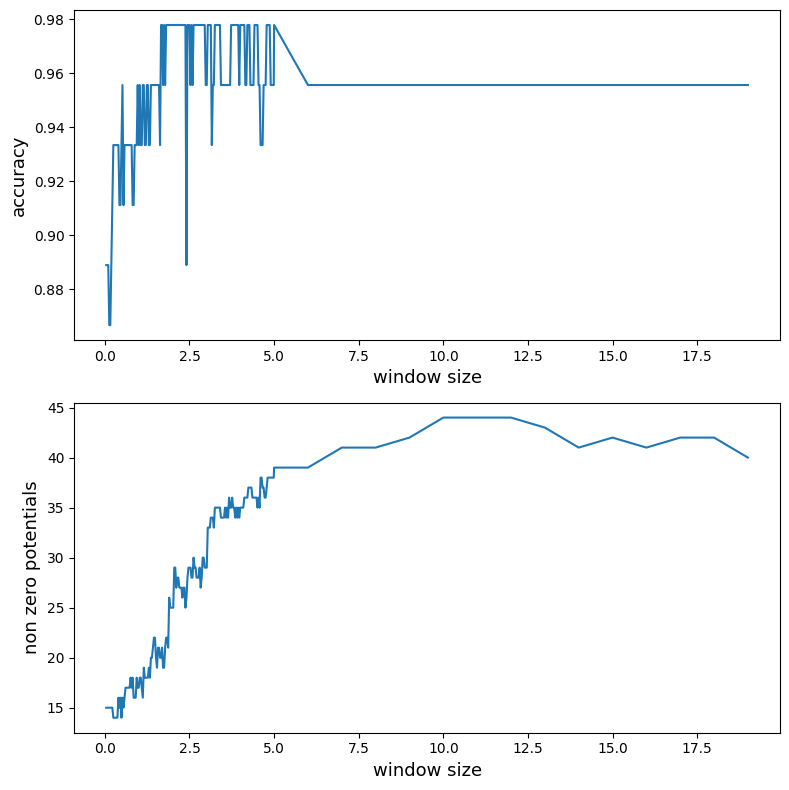

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.xlabel('window size', fontsize=13)
plt.ylabel('accuracy', fontsize=13)
plt.plot(windows, accs)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.xlabel('window size', fontsize=13)
plt.ylabel('non zero potentials', fontsize=13)
plt.plot(windows, pots_counts)
plt.tight_layout()

In [32]:
best_window = windows[np.argmax(accs)]

model = PotentialClassifier(window_size=best_window)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Test acc: ", metrics.accuracy_score(y_test, pred))
print("Train acc: ", metrics.accuracy_score(y_train, model.predict(X_train)))
print("Whole data acc: ", metrics.accuracy_score(y, model.predict(X)))

Test acc:  0.8888888888888888
Train acc:  0.9619047619047619
Whole data acc:  0.94


## Подбираем параметры

In [33]:
def Validate(clf, n_splits=5):
    best_classifier = None
    best_accuracy = 0

    kf = KFold(n_splits=n_splits)
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_split_train, y_split_train = X_train[train_index], y_train[train_index]
        X_split_valid, y_split_valid = X_train[val_index], y_train[val_index]

        clf_fold = clone(clf)
        clf_fold.fit(X_split_train, y_split_train)

        pred = clf_fold.predict(X_split_valid)
        accu = metrics.accuracy_score(y_split_valid, pred)

        if accu > best_accuracy:
            best_accuracy = accu
            best_classifier = clf_fold

    return best_classifier

In [34]:
epochs = [5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 50]
windows = np.hstack([np.arange(0.04, 5, 0.03), np.arange(5, 20, 1)])

best_model = None
best_acc = 0
best_window = 0
best_epochs = 0

for num_epoch in epochs:
    print("%d epochs:" % (num_epoch))
    for window in tqdm(windows):
        model = PotentialClassifier(window_size=window, num_epoch=num_epoch)
        scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=16, scoring='accuracy')
        accuracy = scores.mean()

        if accuracy > best_acc:
            best_window = window
            best_epochs = num_epoch
            best_model = PotentialClassifier(window_size=window, num_epoch=num_epoch).fit(X_train, y_train)
            best_acc = accuracy

5 epochs:


100%|██████████| 181/181 [00:07<00:00, 24.75it/s]


6 epochs:


100%|██████████| 181/181 [00:06<00:00, 28.45it/s]


7 epochs:


100%|██████████| 181/181 [00:06<00:00, 26.55it/s]


8 epochs:


100%|██████████| 181/181 [00:07<00:00, 23.82it/s]


9 epochs:


100%|██████████| 181/181 [00:08<00:00, 20.18it/s]


10 epochs:


100%|██████████| 181/181 [00:08<00:00, 20.73it/s]


13 epochs:


100%|██████████| 181/181 [00:11<00:00, 16.30it/s]


15 epochs:


100%|██████████| 181/181 [00:12<00:00, 14.55it/s]


20 epochs:


100%|██████████| 181/181 [00:15<00:00, 11.37it/s]


25 epochs:


100%|██████████| 181/181 [00:19<00:00,  9.39it/s]


30 epochs:


100%|██████████| 181/181 [00:22<00:00,  7.95it/s]


35 epochs:


100%|██████████| 181/181 [00:25<00:00,  7.04it/s]


40 epochs:


100%|██████████| 181/181 [00:29<00:00,  6.07it/s]


50 epochs:


100%|██████████| 181/181 [00:36<00:00,  4.96it/s]


In [35]:
print("Best model: h = %f, ne = %d" % (best_window, best_epochs))

model = PotentialClassifier(window_size=best_window, num_epoch=best_epochs)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Train acc: ", best_acc)
print("Test acc: ", metrics.accuracy_score(y_test, pred))

Best model: h = 2.740000, ne = 5
Train acc:  0.980952380952381
Test acc:  0.9555555555555556


## Смотрим на ненулевые потенциалы

[2 2 2 1 2 1 2 1 2 1 1 1 1 4 1 2 3 3 3 1]


Text(0, 0.5, 'petal width (cm)')

<Figure size 640x480 with 0 Axes>

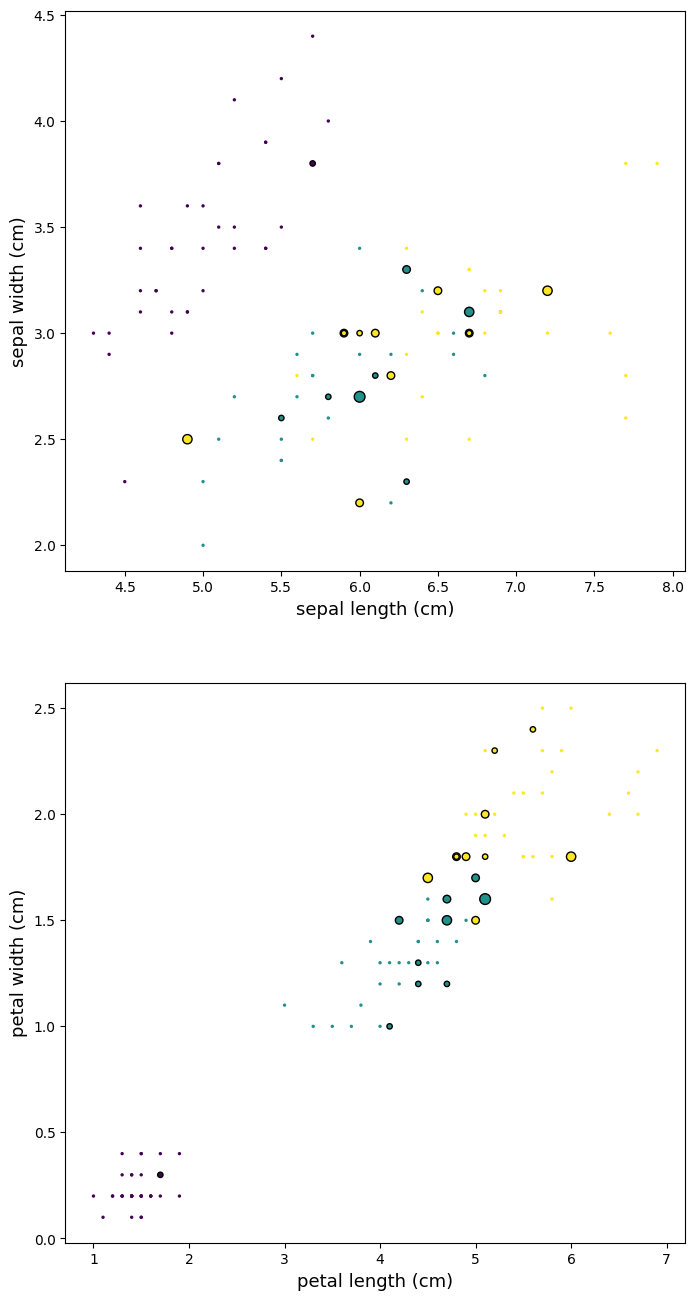

In [36]:
plt.clf()
fig = plt.figure(figsize=(8, 16))

indices = model.pot_ids
print(model.pots)
X_non_zeroed = X_train[indices]
y_non_zeroed = y_train[indices]

sep_plt = fig.add_subplot(211)
sep_plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=2, edgecolor=None)
sep_plt.scatter(X_non_zeroed[:, 0], X_non_zeroed[:, 1], c=y_non_zeroed, s=15*model.pots, edgecolor="k")
sep_plt.set_xlabel(feature_names[0], fontsize=13)
sep_plt.set_ylabel(feature_names[1], fontsize=13)

pet_plt = fig.add_subplot(212)
pet_plt.scatter(X_train[:, 2], X_train[:, 3], c=y_train, s=2, edgecolor=None)
pet_plt.scatter(X_non_zeroed[:, 2], X_non_zeroed[:, 3], c=y_non_zeroed, s=15*model.pots, edgecolor="k")
pet_plt.set_xlabel(feature_names[2], fontsize=13)
pet_plt.set_ylabel(feature_names[3], fontsize=13)

## Смотрим на ошибки

Text(0, 0.5, 'petal width (cm)')

<Figure size 640x480 with 0 Axes>

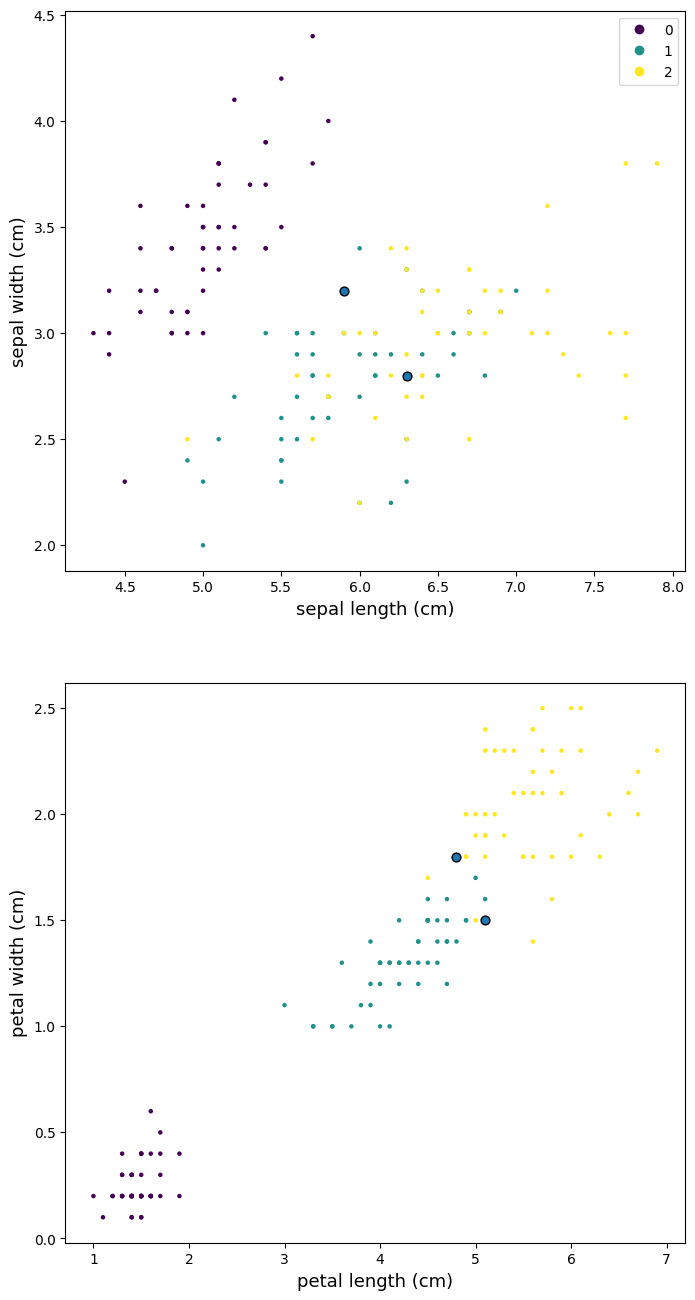

In [45]:
plt.clf()
fig = plt.figure(figsize=(8, 16))

indices = (y_test != pred)
X_non_zeroed = X_test[indices]
y_non_zeroed = y_test[indices]

sep_plt = fig.add_subplot(211)
sep_scatter = sep_plt.scatter(X[:, 0], X[:, 1], c=y, s=5, edgecolor=None)
sep_plt.scatter(X_non_zeroed[:, 0], X_non_zeroed[:, 1], s=40, edgecolor="k")
sep_plt.set_xlabel(feature_names[0], fontsize=13)
sep_plt.set_ylabel(feature_names[1], fontsize=13)
sep_plt.legend(handles=sep_scatter.legend_elements()[0], labels=['0', '1', '2'])

pet_plt = fig.add_subplot(212)
pet_plt.scatter(X[:, 2], X[:, 3], c=y, s=5, edgecolor=None)
pet_plt.scatter(X_non_zeroed[:, 2], X_non_zeroed[:, 3], s=40, edgecolor="k")
pet_plt.set_xlabel(feature_names[2], fontsize=13)
pet_plt.set_ylabel(feature_names[3], fontsize=13)

In [38]:
print("Predicted: ")
print(pred[indices])
print("GT: ")
print(y_test[indices])

Predicted: 
[2 1]
GT: 
[1 2]


In [39]:
indices = model.pot_ids
print(len(X_train[indices]))
print(len(np.unique((X_train[indices])[:, :2], axis=0)))

20
17
